# Single row of turbines

We start with the imports for this example:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import foxes
import foxes.variables as FV

The `foxes` setup is described in the `Overview` section. In summary, it consists of creating: 

1. The so-called `model book`, which contains all selectable models
2. Ambient wind conditions, called `states` in `foxes` terminology
3. The `wind farm`, collecting all turbine information
4. The `algorithm` with its parameters and model choices

Here is a simple example for a single row of turbines along the x axis and a uniform wind speed with wind direction 270°:

In [2]:
# Create model book and add turbine type model:
# The csv file will be searched in the file system,
# and if not found, taken from static library.
#
# Note that we could actually skip adding the "NREL5"
# model and use "NREL5MW" which already exists in the
# default model book. Here this is for demonstrational
# purposes, in case you have your own turbine file:
mbook = foxes.ModelBook()
mbook.turbine_types["NREL5"] = foxes.models.turbine_types.PCtFile(
    "NREL-5MW-D126-H90.csv"
)

# create ambient wind conditions, a single uniform state:
states = foxes.input.states.SingleStateStates(ws=9.0, wd=270.0, ti=0.12, rho=1.225)

# create wind farm, a single row of turbines:
farm = foxes.WindFarm()
foxes.input.farm_layout.add_row(
    farm=farm,
    xy_base=[0.0, 0.0],
    xy_step=[800.0, 0.0],
    n_turbines=5,
    turbine_models=["NREL5"],
    verbosity=0,
)

# setup the calculation algorithm:
algo = foxes.algorithms.Downwind(
    mbook, farm, states, verbosity=0, wake_models=["Jensen_linear_k007"]
)

Now we can ask the `algorithm` object to run the calculation. This returns a `xarray.Dataset` object with results for each state and turbine:

In [3]:
farm_results = algo.calc_farm()
print("\nFarm results:\n", farm_results)


Farm results:
 <xarray.Dataset>
Dimensions:    (state: 1, turbine: 5)
Coordinates:
  * state      (state) int64 0
Dimensions without coordinates: turbine
Data variables: (12/25)
    weight     (state, turbine) float64 1.0 1.0 1.0 1.0 1.0
    X          (state, turbine) float64 0.0 800.0 1.6e+03 2.4e+03 3.2e+03
    Y          (state, turbine) float64 0.0 0.0 0.0 0.0 0.0
    H          (state, turbine) float64 90.0 90.0 90.0 90.0 90.0
    D          (state, turbine) float64 126.0 126.0 126.0 126.0 126.0
    P          (state, turbine) float64 2.519e+03 1.557e+03 ... 1.107e+03
    ...         ...
    AMB_TI     (state, turbine) float64 0.12 0.12 0.12 0.12 0.12
    AMB_RHO    (state, turbine) float64 1.225 1.225 1.225 1.225 1.225
    order      (state, turbine) int64 0 1 2 3 4
    AMB_P      (state, turbine) float64 2.519e+03 2.519e+03 ... 2.519e+03
    AMB_CT     (state, turbine) float64 0.79 0.79 0.79 0.79 0.79
    tname      (turbine) <U2 'T0' 'T1' 'T2' 'T3' 'T4'


For a convenient summary printout we can easily convert the results into a `pandas.DataFrame`:

In [4]:
fr = farm_results.to_dataframe()
print(fr[[FV.WD, FV.AMB_REWS, FV.REWS, FV.TI, FV.AMB_P, FV.P, FV.CT]])

                  WD  AMB_REWS      REWS    TI   AMB_P            P        CT
state turbine                                                                
0     0        270.0       9.0  9.000000  0.12  2518.6  2518.600000  0.790000
      1        270.0       9.0  7.633459  0.12  2518.6  1557.076947  0.803665
      2        270.0       9.0  7.176627  0.12  2518.6  1290.332498  0.808234
      3        270.0       9.0  6.955794  0.12  2518.6  1167.325199  0.812210
      4        270.0       9.0  6.821354  0.12  2518.6  1106.880886  0.818932


Once the farm calculation results are ready, we can evaluate the wake corrected flow and all points of interest. For example, we can evaluate the wind speed along the centre line:


Point results:
 <xarray.Dataset>
Dimensions:  (state: 1, point: 8000)
Coordinates:
  * state    (state) int64 0
Dimensions without coordinates: point
Data variables:
    WS       (state, point) float64 9.0 9.0 9.0 9.0 ... 8.916 8.916 8.916 8.916
    WD       (state, point) float64 270.0 270.0 270.0 ... 270.0 270.0 270.0
    TI       (state, point) float64 0.12 0.12 0.12 0.12 ... 0.12 0.12 0.12 0.12
    RHO      (state, point) float64 1.225 1.225 1.225 ... 1.225 1.225 1.225
    AMB_WS   (state, point) float64 9.0 9.0 9.0 9.0 9.0 ... 9.0 9.0 9.0 9.0 9.0
    AMB_WD   (state, point) float64 270.0 270.0 270.0 ... 270.0 270.0 270.0
    AMB_TI   (state, point) float64 0.12 0.12 0.12 0.12 ... 0.12 0.12 0.12 0.12
    AMB_RHO  (state, point) float64 1.225 1.225 1.225 ... 1.225 1.225 1.225


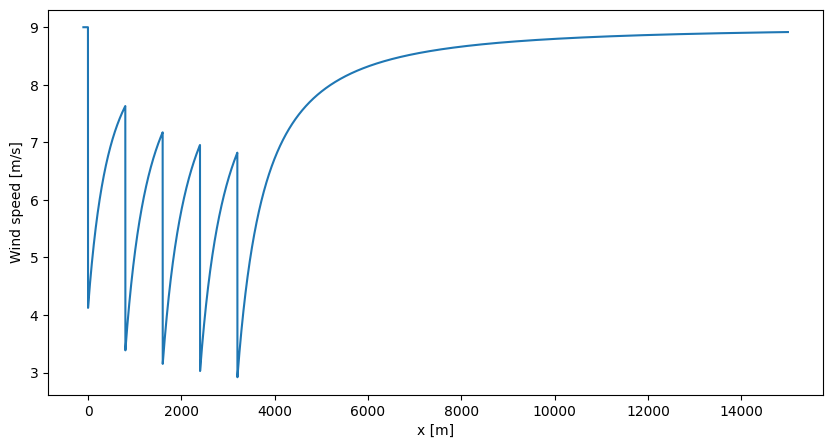

In [5]:
# infer hub height from turbine type:
H = mbook.turbine_types["NREL5"].H

# create points of interest, shape (n_states, n_points, 3):
n_points = 8000
points = np.zeros((1, n_points, 3))
points[:, :, 0] = np.linspace(-100.0, 15000.0, n_points)[None, :]
points[:, :, 2] = H

# calculate point results:
point_results = algo.calc_points(farm_results, points)
print("\nPoint results:\n", point_results)

# create figure:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(points[0, :, 0], point_results[FV.WS][0, :])
ax.set_xlabel("x [m]")
ax.set_ylabel("Wind speed [m/s]")
plt.show()

The `foxes.output` package provides a collection of standard outputs. For example, we can visualize the flow field in a horizontal slice at hub height:

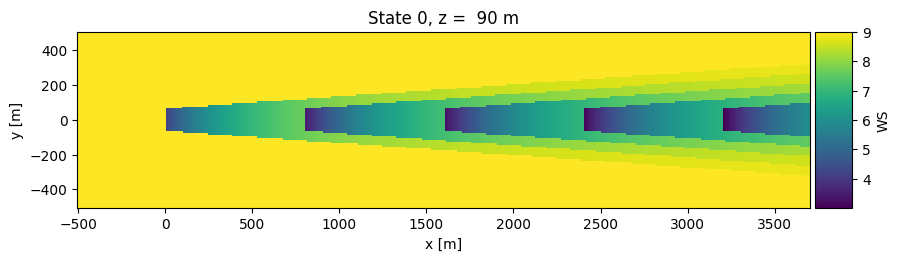

In [7]:
o = foxes.output.FlowPlots2D(algo, farm_results)
g = o.gen_states_fig_xy("WS", resolution=10, figsize=(10, 5), verbosity=0)
fig = next(g)  # creates the figure for the next state, here there is only state 0
plt.show()